# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
goldstone_start = goldstone_end - 5*u.hour
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
fit_offsets = np.arange(0, (goldstone_end - goldstone_start)/(1*u.s), sampling_interval)
fit_epochs = goldstone_start + (fit_offsets << u.s)
print("Start and end epochs:", goldstone_start, fit_epochs[-1], "[", fit_epochs.size, "]")

Start and end epochs: 1998-01-23 01:14:55.600 1998-01-23 06:14:55.600 [ 301 ]


In [3]:
near_goldstone_start_rv = Ephem.from_horizons("NEAR", goldstone_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(goldstone_start)
describe_state(near_goldstone_start_rv, dss25, goldstone_start)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_start_rv[0], near_goldstone_start_rv[1], goldstone_start)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 01:14:55.600
Geocentric distance: 170567.65621007947 km speed: 7.183503343208053 km / s
From Goldstone-25 : range  166458.07986262924 km , range rate  -7.465920108908227 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9732496436772 deg
Eccentricity: 1.8134996008951505
Semilatus rectum: 19440.235051668238 km
Semimajor axix: -8493.707667805164 km
Periapse radius: 6909.62779787958 km , altitude: 531.4911978795799 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(fit_epochs))
describe_trajectory(near_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 166010.12785733113 km 31573.915329633066 km
Start and end radial speeds: -7.465920108908282 km / s -7.684678614009732 km / s
Closest: 31573.915329633066 km speed 8.258629481934712 km / s  at  1998-01-23 06:14:55.600
Deflection: 1.4531854375528002 deg


In [5]:
ref_data = []
sim_meas_data = []
for o in fit_offsets:
    e = goldstone_start + o*u.s
    rv = near_goldstone_ephem.rv(e)
    ref_r, ref_rr, ref_ra = dss25.range_rate_accel(rv, e)
    ref_data.append(ref_rr)
    sim_meas_data.append(ref_rr - ref_ra*ref_r/const.c)

print(ref_data)
print(sim_meas_data)

[<Quantity -7.46592011 km / s>, <Quantity -7.46581302 km / s>, <Quantity -7.46570352 km / s>, <Quantity -7.46559165 km / s>, <Quantity -7.46547745 km / s>, <Quantity -7.46536096 km / s>, <Quantity -7.46524222 km / s>, <Quantity -7.46512126 km / s>, <Quantity -7.46499812 km / s>, <Quantity -7.46487286 km / s>, <Quantity -7.46474549 km / s>, <Quantity -7.46461608 km / s>, <Quantity -7.46448466 km / s>, <Quantity -7.46435127 km / s>, <Quantity -7.46421595 km / s>, <Quantity -7.46407874 km / s>, <Quantity -7.4639397 km / s>, <Quantity -7.46379885 km / s>, <Quantity -7.46365625 km / s>, <Quantity -7.46351194 km / s>, <Quantity -7.46336597 km / s>, <Quantity -7.46321837 km / s>, <Quantity -7.46306919 km / s>, <Quantity -7.46291848 km / s>, <Quantity -7.46276628 km / s>, <Quantity -7.46261264 km / s>, <Quantity -7.46245761 km / s>, <Quantity -7.46230124 km / s>, <Quantity -7.46214356 km / s>, <Quantity -7.46198463 km / s>, <Quantity -7.4618245 km / s>, <Quantity -7.46166322 km / s>, <Quantity

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, dss25)
fitter.set_debug()
fitter.fit_doppler_data(fit_offsets, sim_meas_data)
print(fitter.report())

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

{'a': -8493707.667805163, 'ecc': 1.8134996008951507, 'nu': -2.081249407419048, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951507, 'nu': -2.081249407419048, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951507, 'nu': -2.081249407419048, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951507, 'nu': -2.081249407419048, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996035974755, 'nu': -2.081249407419048, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951507, 'nu': -2.0812493820261686, 'inc': 1.8844887103599615, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, '

{'a': -8493707.667805163, 'ecc': 1.8116768569733566, 'nu': -2.0820219296447324, 'inc': 1.8882806603471567, 'raan': 1.5418358611165222, 'argp': 2.534837547287842}
{'a': -8493707.667805163, 'ecc': 1.811673081784427, 'nu': -2.0820235295714706, 'inc': 1.8882883903007746, 'raan': 1.5418395069906057, 'argp': 2.5348408803035913}
{'a': -8493707.667805163, 'ecc': 1.8116764877621803, 'nu': -2.0820220860609027, 'inc': 1.8882814163913813, 'raan': 1.5418362175220455, 'argp': 2.534837865274421}
{'a': -8493707.667805163, 'ecc': 1.8116768569733566, 'nu': -2.0820219296447324, 'inc': 1.8882806603471567, 'raan': 1.5418358611165222, 'argp': 2.5348375383606196}
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 301
    # variables        = 6
    chi-square         = 3.5509e-06
    reduced chi-square = 1.2037e-08
    Akaike info crit   = -5482.88437
    Bayesian info crit = -5460.64170
##  Warning: uncertainties could not be estimated:
    a:     at init

In [7]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [8]:
sim_goldstone_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(sim_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32462.70310630134 km 14331.856814136734 km
Start and end radial speeds: -7.679090062465085 km / s -6.934396213605276 km / s
Closest: 14331.856814136734 km speed 9.4281283132142 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.300387675444539 deg


In [9]:
# also extend the reference trajectory
near_goldstone_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(ssn_epochs))

In [10]:
altair_residuals = []
millstone_residuals = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = sim_goldstone_ephem.rv(e)
    sim_rv = near_goldstone_extended_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_residuals.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_residuals.append((meas_r - ref_r).to_value(u.m))

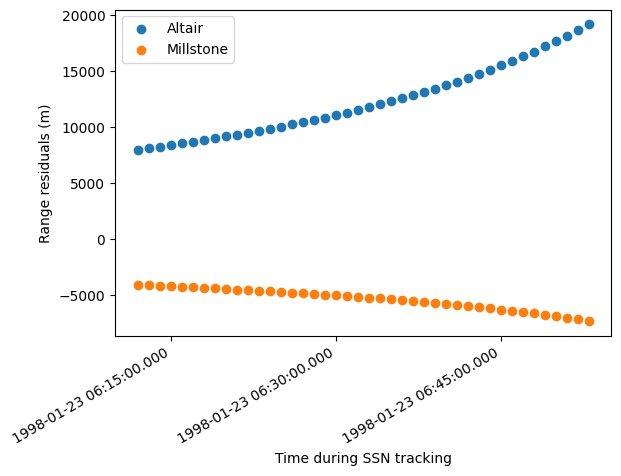

In [11]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.scatter(ssn_epochs, altair_residuals, label="Altair")
    plt.scatter(ssn_epochs, millstone_residuals, label="Millstone")
    plt.legend(loc=0)
    plt.gcf().autofmt_xdate()

In [12]:
from czml3.widget import CZMLWidget
from poliastro.czml.extract_czml import CZMLExtractor

czml = CZMLExtractor(ssn_epochs[0], ssn_epochs[-1], ssn_epochs.size)
#dss25.add_to_czml(czml, "#333")
#dss34.add_to_czml(czml, "#333")
ssrAltair.add_to_czml(czml, "#111")
ssrMillstone.add_to_czml(czml, "#111")
czml.add_orbit(near_goldstone_orbit)
czml.add_orbit(fitter.orbit)

CZMLWidget(czml.get_document())

CZMLWidget(document=Document(_values=[Preamble(id='document', version='1.0', name='document_packet', description=None, clock=IntervalValue(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>, _value=Clock(currentTime=datetime.datetime(1998, 1, 23, 6, 12, tzinfo=datetime.timezone.utc), multiplier=60, range=<ClockRanges.LOOP_STOP: 3>, step=<ClockSteps.SYSTEM_CLOCK_MULTIPLIER: 2>))), Packet(id='custom_properties', delete=None, name=None, parent=None, description=None, availability=None, properties={'custom_attractor': True, 'ellipsoid': [{'array': (6378136.6, 6378136.6, 6356751.9)}], 'map_url': ('https://upload.wikimedia.org/wikipedia/commons/c/c4/Earthmap1000x500compac.jpg',), 'scene3D': True}, position=None, orientation=None, viewFrom=None, billboard=None, box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=None, model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS0', delete=None, name=None, parent=None, description='Altair', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[-6143471.429543289, 1364300.4818256705, 1034339.9636133286], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<LabelStyles.FILL: 1>, scale=None, showBackground=None, backgroundColor=None, fillColor=Color(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, rgba='#111', rgbaf=None), outlineColor=None, outlineWidth=1.0, pixelOffset=None), model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS1', delete=None, name=None, parent=None, description='Millstone', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[1492298.8700490487, -4457675.543085808, 4296323.883602885], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<Labe

See [screenshot](near_sim_ssn_altbydoppler_trajectory.png)